In [21]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [22]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


In [3]:
# Generating Empty Aggregator to be loaded 

setting = 'FedAvg'

if setting == 'FedEM':
    nL = 3
else:
    nL = 1
    
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = setting
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= nL
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/dummy/'
args_.validation = False

# Generate the dummy values here
try:
    aggregator
except:
    aggregator, clients = dummy_aggregator(args_, num_user=40)

try:
    dataloader
except:
    # Compiling Dataset from Clients
    # Combine Validation Data across all clients as test
    data_x = []
    data_y = []

    for i in range(len(clients)):
        daniloader = clients[i].test_iterator
        for (x,y,idx) in daniloader.dataset:
            data_x.append(x)
            data_y.append(y)

    data_x = torch.stack(data_x)
    try:
        data_y = torch.stack(data_y)        
    except:
        data_y = torch.FloatTensor(data_y) 

    dataloader = Custom_Dataloader(data_x, data_y)
    global_dataloader = copy.deepcopy(dataloader)
    
# del aggregator, clients

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 262.00it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:14<00:00,  5.36it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [10]:
def get_models_test(directory_name, num_models):
    # Generate the dummy values here
    aggregator, clients = dummy_aggregator(args_, num_user=num_models)
    
    # Combined version
    args_.save_path = directory_name
    weights = np.load(directory_name+'train_client_weights.npy')
    aggregator.load_state(args_.save_path)
    
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []
    
    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    # Set model weights
    model_weights = []

    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0[0]*weights_h[0][key]
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
        
    # For h_s
    h_s = []

    
    del aggregator
    
    return weights, models_test, h_s, clients

def generate_empty_logs_adv(num_models):
    
    # Here we will make a dictionary that will hold results
    logs_adv = []

    for i in range(num_models):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None

        logs_adv += [adv_dict]
    
    return logs_adv
        
# Perform transfer attack from one client to another and record stats

def adv_atk(models_test, num_models, clients, custom_batch_size = 500):
    
    # Run Measurements for both targetted and untargeted analysis
    new_num_models = len(models_test)
    victim_idxs = range(new_num_models)
    custom_batch_size = 500
    eps = 4.5
    
    # Record number of batch sizes
    batch_size_recs = np.ones([num_models,num_models])
    victim_idxs = range(num_models)
    logs_adv = generate_empty_logs_adv(num_models)
    
    print("Running Adv Attack")
    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)

        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        batch_size_recs[adv_idx,:] *= batch_size

        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)

        # Perform Attacks Targeted
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = eps, eps_norm = 2)



        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)

        # Log Performance
        logs_adv[adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        logs_adv[adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        logs_adv[adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        logs_adv[adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        logs_adv[adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack Untargeted
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = eps, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        logs_adv[adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        logs_adv[adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)
        
    return logs_adv

def logs_adv_analysis(logs_adv):
    
    logs_analyzed_dict = {}
    
    new_num_models = len(logs_adv)
    num_models = len(logs_adv)
    
    metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']

    orig_acc = np.zeros([new_num_models, new_num_models]) 
    orig_sim = np.zeros([new_num_models, new_num_models]) 
    adv_acc = np.zeros([new_num_models, new_num_models]) 
    adv_sim_target = np.zeros([new_num_models, new_num_models]) 
    adv_sim_untarget = np.zeros([new_num_models, new_num_models]) 
    adv_target = np.zeros([new_num_models, new_num_models])
    adv_miss = np.zeros([new_num_models, new_num_models]) 

    for adv_idx in range(num_models):
        for victim in range(num_models):
            orig_acc[adv_idx,victim] = logs_adv[adv_idx][metrics[0]][victim].data.tolist()
            orig_sim[adv_idx,victim] = logs_adv[adv_idx][metrics[1]][victim].data.tolist()
            adv_acc[adv_idx,victim] = logs_adv[adv_idx][metrics[2]][victim].data.tolist()
            adv_sim_target[adv_idx,victim] = logs_adv[adv_idx][metrics[3]][victim].data.tolist()
            adv_sim_untarget[adv_idx,victim] = logs_adv[adv_idx][metrics[4]][victim].data.tolist()
            adv_target[adv_idx,victim] = logs_adv[adv_idx][metrics[5]][victim].data.tolist()
            adv_miss[adv_idx,victim] = logs_adv[adv_idx][metrics[6]][victim].data.tolist()
            
        
    logs_analyzed_dict['orig_acc'] = orig_acc
    logs_analyzed_dict['orig_sim'] = orig_sim
    logs_analyzed_dict['adv_acc'] = adv_acc
    logs_analyzed_dict['adv_sim_target'] = adv_sim_target
    logs_analyzed_dict['adv_sim_target'] = adv_sim_untarget
    logs_analyzed_dict['adv_target'] = adv_target
    logs_analyzed_dict['adv_miss'] = adv_miss
    
    return logs_analyzed_dict

def measure_IB(models_test, dataloader, num_trials = 20, batch_size = 300):
    
    print("IB TEST")
    dists_measure_legit = np.zeros([len(models_test),num_trials, len(models_test)])
    dists_measure_adv = np.zeros([len(models_test),num_trials, len(models_test)])

    # attack parameters -- hard wired for now
    eps = 4.5
    iteration = 10
    target = -1
    eps_norm = 2
    step_size = 0.01

    t1 = Boundary_Transferer(models_list=models_test, dataloader=dataloader)

    for j in range(len(models_test)):

        for i in range(num_trials):
            print("basemodel:", j, "IB num_trial:", i)
            t1.base_nn_idx = j
            t1.victim_idx = range(len(models_test))

            t1.atk_params = IFSGM_Params()
            t1.atk_params.set_params(batch_size=1, eps=0.1, alpha=0.01, iteration = 30,
                               target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x))

            t1.set_adv_NN(t1.base_nn_idx)

            base_ep_legit, victim_eps_legit = t1.legitimate_direction(batch_size=batch_size, ep_granularity = 0.1, 
                                                                      rep_padding = 1000, new_point = True,print_res = False)

            base_ep_adv, victim_eps_adv = t1.adversarial_direction(ep_granularity = 0.1, 
                                                                      rep_padding = 1000, new_point = False,print_res = False)

            idx = 0
            for key, value in victim_eps_legit.items():
                dists_measure_legit[j,i,idx] = np.abs(base_ep_legit-value)
                idx+=1

            idx = 0
            for key, value in victim_eps_adv.items():
                dists_measure_adv[j,i,idx] = np.abs(base_ep_adv - value)
                idx+=1
    
    # Post filtering
    # Filter data for adv and legit

    for i in range(len(models_test)):
        for j in range(dists_measure_legit[i].shape[0]):
            if dists_measure_legit[i][j][i] > 0:
                dists_measure_legit[i][j][i] = 0
        for j in range(dists_measure_legit[i].shape[0]):
            if dists_measure_adv[i][j][i] > 0:
                dists_measure_adv[i][j][i] = 0

#     ib_legit = np.mean(filtered_dists_measure_legit,axis=0)
#     ib_adv = np.mean(filtered_dists_measure_adv,axis=0)
    return dists_measure_legit, dists_measure_adv

In [56]:
# base_name = 'weights/unlearning/cifar10/22_09_25_UNL_client_sweep/'
base_name = 'weights/unlearning/cifar10/22_09_26_non_participant_sweep_try2/'

directory_names = ['adv_usr_0/', 'adv_usr_5/' , 'adv_usr_10/', 'adv_usr_15/', 'adv_usr_20/']

num_models_list = [40,40,40,40,40]

# IB test parameters
ib_model_threshold = 10 # Number of models to use for IB analysis
num_trials = 1
batch_size = 400

# Store values
var_dict = {}
orig_acc_dict = {}
adv_miss_dict = {}
ib_dist_dict = {}
ib_dist_dict_compressed = {}

In [57]:
logs_dict = {}
for i in range(len(directory_names)):
     
    print("EXP:", directory_names[i][:-1])
    weights, models_test, h_s, clients = get_models_test(base_name+directory_names[i], num_models_list[i])
    logs_adv = adv_atk(models_test, num_models_list[i], clients, custom_batch_size = 500)
    logs_dict[directory_names[i][:-1]] = logs_adv_analysis(logs_adv)
    
    # Extract Values of Relevance
    orig_acc = logs_dict[directory_names[i][:-1]]['orig_acc']
    orig_acc_dict[directory_names[i][:-1]] = np.mean(np.diagonal(orig_acc))
    
    adv_miss = logs_dict[directory_names[i][:-1]]['adv_miss']
    adv_miss_dict[directory_names[i][:-1]] = np.mean(np.diagonal(adv_miss))
    
    var = np.var(weights, axis=0)
    var_dict[directory_names[i][:-1]] = var


EXP: adv_usr_0
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 347.50it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.75it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
Running Adv Attack
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
EXP: adv_usr_5
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 342.38it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.87it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
Running Adv Attack
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
EXP: adv_usr_10
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 341.84it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:12<00:00,  6.66it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
Running Adv Attack
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
EXP: adv_usr_15
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 346.41it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:12<00:00,  6.62it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
Running Adv Attack
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
EXP: adv_usr_20
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 342.73it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.67it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.297 | Train Acc: 10.823% |Test Loss: 2.298 | Test Acc: 10.893% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
Running Adv Attack
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


In [58]:
orig_acc_dict

{'adv_usr_0': 0.7240801341831684,
 'adv_usr_5': 0.7193612813949585,
 'adv_usr_10': 0.7164481222629547,
 'adv_usr_15': 0.7151747614145278,
 'adv_usr_20': 0.7151640221476555}

In [59]:
adv_miss_dict

{'adv_usr_0': 0.3556265518069267,
 'adv_usr_5': 0.35602430552244185,
 'adv_usr_10': 0.35594948977231977,
 'adv_usr_15': 0.35962293967604636,
 'adv_usr_20': 0.3650255210697651}

Text(0.5, 1.0, 'CIFAR-10 Benign Client Sweep')

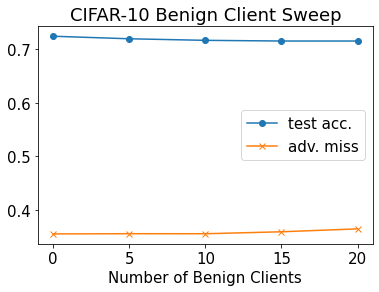

In [62]:
x = [0,5,10,15,20]

test_acc = []
adv_miss = []
for i in orig_acc_dict.keys():
    test_acc += [orig_acc_dict[i]]
    adv_miss += [adv_miss_dict[i]]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


plt.plot(x,test_acc,label= 'test acc.', marker = 'o')
plt.plot(x,adv_miss,label= 'adv. miss', marker = 'x')


plt.legend(frameon=True)
plt.xlabel('Number of Benign Clients')
plt.title("CIFAR-10 Benign Client Sweep")


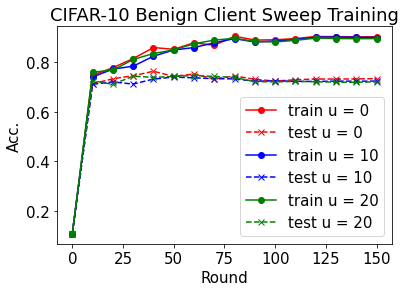

In [63]:
name_sub = ['adv_usr_0/', 'adv_usr_10/', 'adv_usr_20/']
color = ['red', 'blue', 'green']
train_label = ['train u = 0', 'train u = 10', 'train u = 20']
test_label = ['test u = 0', 'test u = 10', 'test u = 20']

for i in range(len(name_sub)):
    name = name_sub[i]
    pickle_name = base_name + name + 'train_log.p'
    with open(pickle_name,'rb') as handle:
        b = pickle.load(handle)
    
    x = b['rounds']
    y1 = b['train_acc']
    y2 = b['test_acc']
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

    plt.rc('font', **font)


    plt.plot(x,y1, marker = 'o', color = color[i], label = train_label[i])
    plt.plot(x,y2, marker = 'x', linestyle = '--', color = color[i], label = test_label[i])


    plt.legend(frameon=True)
    plt.xlabel('Round')
    plt.ylabel('Acc.')
    plt.title("CIFAR-10 Benign Client Sweep Training")